In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split,Dataset
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

import pywt
from scipy.signal import welch

import os
import pandas as pd

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tqdm import tqdm

from xgboost import XGBClassifier
# 設置設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
class EEGUtil:
    @staticmethod
    def load_data(file_path, column_name='spike hz'):
        """Load EEG data from a CSV file."""
        data = pd.read_csv(file_path)
        signal = data[column_name].values
        return signal

    @staticmethod
    def padding(signal, target_length):
        """Pad or truncate signal to the target length."""
        if len(signal) < target_length:
            return np.pad(signal, (0, target_length - len(signal)), 'constant', constant_values=-1)
        return signal[:target_length]

    @staticmethod
    def wavelet_transform(signal):
        """Perform Wavelet Transform and extract features."""
        coeffs = pywt.wavedec(signal, 'db4', level=5)
        features = []
        for i in range(1, len(coeffs)):
            features.extend([np.mean(coeffs[i]), np.std(coeffs[i])])
        return np.array(features)

    @staticmethod
    def psd_transform(signal, fs=0.2, nperseg=128):
        """Perform Power Spectral Density analysis and extract features."""
        freqs, psd = welch(signal, fs=fs, nperseg=nperseg)
        return psd

In [15]:
class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, target_length=600, strategy='padding', use_labels=False):
        self.use_labels=use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
        
        # Load outcomes if provided
        self.outcome_dict = {}
        if use_labels and outcome_file is not None:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            # 仅保留有标签的文件
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        patient_id = filename.split('.')[0]
        file_path = os.path.join(self.data_folder, filename)
        signal = EEGUtil.load_data(file_path, column_name='BCI')

        # Process the signal
        processed_signal = self.process_signal(signal)

        # Get the label if available
        label=-1
        if self.use_labels :
            label = self.get_label(patient_id)
            
        return torch.tensor(processed_signal, dtype=torch.float32).unsqueeze(0), label  # 增加通道维度

    def process_signal(self, signal):
        if self.strategy == 'padding':
            return EEGUtil.padding(signal, self.target_length)
        elif self.strategy == 'wavelet':
            return EEGUtil.wavelet_transform(signal)
        elif self.strategy == 'psd':
            return EEGUtil.psd_transform(signal)
        else:
            raise ValueError("Invalid processing strategy")

    def get_label(self, patient_id):
        if patient_id in self.outcome_dict:
            outcome = self.outcome_dict[patient_id]
            return 1 if outcome == 'Good Outcome' else 0

In [16]:
initial_channels = 128
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim, seq_length):
        super(CNNEncoder, self).__init__()
        self.latent_dim = latent_dim

        layers = [
            nn.Conv1d(1, initial_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        ]

        in_channels = initial_channels
        for i in range(3):  # 3 more layers to make 4 in total
            out_channels = in_channels // 2
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)
        self.fc_mean = nn.Linear(in_channels * seq_length, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * seq_length, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

class CNNDecoder(nn.Module):
    def __init__(self, latent_dim, seq_length):
        super(CNNDecoder, self).__init__()
        self.seq_length=seq_length
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, initial_channels // 8 * seq_length)  # Match the output channel of the encoder

        layers = [nn.LeakyReLU()]
        in_channels = initial_channels // 8
        for i in range(3):
            out_channels = in_channels * 2
            layers.extend([
                nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels
        
        # Remove the last LeakyReLU and add a final ConvTranspose to match the Encoder's starting channel
        layers.pop()
        layers.append(nn.ConvTranspose1d(in_channels, 1, kernel_size=3, stride=1, padding=1))

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), initial_channels // 8, self.seq_length)
        x = self.decoder(x)
        return F.leaky_relu(x)


class VAE(nn.Module):
    def __init__(self, latent_dim, seq_length):  # 接受 seq_length 作为参数
        super(VAE, self).__init__()
        self.seq_length=seq_length
        self.latent_dim = latent_dim
        self.encoder = CNNEncoder(latent_dim, seq_length)  # 将 seq_length 传递给 CNNEncoder
        self.decoder = CNNDecoder(latent_dim, seq_length)  # 将 seq_length 传递给 CNNDecoder

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mean, logvar

    def get_embedding(self, x):
        self.eval()
        with torch.no_grad():
            mean, logvar = self.encoder(x)
            z = self.reparameterize(mean, logvar)
        return z


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [18]:
def train(model, dataloader, optimizer, criterion, alpha, kl_loss_enabled=True):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for data, label in dataloader:  # We don't use the labels during unsupervised training for VAE
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass through the model
        reconstruction, mean, logvar = model(data)

        # Compute the reconstruction loss (mean squared error)
        recon_loss = criterion(reconstruction, data)

        # Compute the KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

        # Combine the losses
        loss = recon_loss + (alpha * kl_loss if kl_loss_enabled else 0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)  # Accumulate the total loss for this batch

    epoch_loss = running_loss / len(dataloader.dataset)  # Calculate the average loss per sample
    return epoch_loss


def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for data, label in dataloader:  # 注意：解包数据，将信号和标签分别取出
            data = data.to(device)
            reconstruction, _, _ = model(data)
            loss = criterion(reconstruction, data)
            running_loss += loss.item() * data.size(0)
    return running_loss / len(dataloader.dataset)

def get_latent_variables(model, dataloader):
    model.eval()
    all_latent_vars = []
    with torch.no_grad():
        for data, label  in dataloader:
            data = data.to(device)
            _, mean, _ = model(data)
            all_latent_vars.append(mean.detach().cpu())
    return torch.cat(all_latent_vars)


def extract_latent_features(vae_model, dataset):
    latent_features = []
    labels = []

    for i in range(len(dataset)):
        signal, label = dataset[i]  # 从数据集中获取信号和标签

        # 将信号放入设备
        signal = signal.unsqueeze(0).to(device)  # 增加 batch 维度

        # 获取潜在表示
        with torch.no_grad():
            latent_vector = vae_model.get_embedding(signal).cpu().numpy()
        latent_features.append(latent_vector.flatten())
        
        labels.append(label)

    return np.array(latent_features), np.array(labels)

In [19]:
def train_and_evaluate(data_folder, valid_outcome_data, latent_dim=10, initial_channels=128, seq_length=1139,
                       batch_size=32, epochs=100, alpha=1e-6, patience=3, strategy='padding'):
    # 1. 创建 EEG 数据集和数据加载器
    eeg_dataset = EEGDataset(data_folder, valid_outcome_data, target_length=seq_length, strategy=strategy, use_labels=False)
    train_size = int(0.8 * len(eeg_dataset))
    test_size = len(eeg_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 2. 定义 VAE 模型、损失函数和优化器
    vae_model = VAE(latent_dim, seq_length).to(device)  # 传递 seq_length
    criterion = nn.MSELoss()
    optimizer = optim.Adam(vae_model.parameters(), lr=1e-3, weight_decay=1e-4)

    # 3. 训练和测试损失列表，用于绘制曲线
    train_losses = []
    test_losses = []

    # 4. 早停相关变量
    best_test_loss = float('inf')
    epochs_no_improve = 0

    # 5. 训练循环
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        train_loss = train(vae_model, train_loader, optimizer, criterion, alpha)
        test_loss = test(vae_model, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        #print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        # 检查早停条件
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            #print("Validation loss has not improved for {} epochs. Early stopping...".format(patience))
            break

    # 6. 提取潜在特征
    eeg_dataset_with_outcomes = EEGDataset(data_folder, valid_outcome_data, target_length=seq_length, strategy=strategy, use_labels=True)
    latent_features, labels = extract_latent_features(vae_model, eeg_dataset_with_outcomes)

    # 7. 使用分层划分进行训练和测试集划分
    X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.3, stratify=labels, random_state=42)

    # 8. 创建并训练 SVM 模型
    #svm_model = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
    #svm_model.fit(X_train, y_train)

    # 9. 预测并评估模型
    #y_pred = svm_model.predict(X_test)
    #accuracy = accuracy_score(y_test, y_pred)

    #print(f"Accuracy of SVM on latent features: {accuracy:.4f}")
    #print("\nClassification Report:")
    #report = classification_report(y_test, y_pred, output_dict=True)
    #print(report)
    #print("\nConfusion Matrix:")
    #cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    #print("\n")
    #======================================================================================
    # 8. 创建并训练 XGBoost 模型
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # 设定不使用标签编码
    xgb_model.fit(X_train, y_train)

    # 9. 预测并评估模型
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy of XGBoost on latent features: {accuracy:.4f}")
    report = classification_report(y_test, y_pred, output_dict=True)
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)


    # 10. 返回结果
    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'svm_accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': cm.tolist()  # 保存为列表格式
    }


In [20]:
import os
import pandas as pd

def optimize_latent_dimensions(data_folder, valid_outcome_data, min_latent_dim=1, max_latent_dim=100, 
                               initial_channels=128, seq_length=1139, batch_size=32, 
                               epochs=100, alpha=1e-6, patience=10, strategy='padding'):
    # 检查结果文件是否存在
    results_file = 'latent_optimization_results.csv'
    
    if os.path.exists(results_file):
        # 读取已存在的结果文件
        existing_results = pd.read_csv(results_file)
        last_latent_dim = existing_results['Latent Dimension'].max()  # 找到最后一次的潜在维度
    else:
        # 如果文件不存在，则从最小潜在维度开始
        last_latent_dim = min_latent_dim - 1

    # 遍历潜在维度
    for latent_dim in range(last_latent_dim + 1, max_latent_dim + 1):
        print(f"Training VAE with latent dimension: {latent_dim}")
        results = train_and_evaluate(data_folder=data_folder, valid_outcome_data=valid_outcome_data,
                                      latent_dim=latent_dim, initial_channels=initial_channels,
                                      seq_length=seq_length, batch_size=batch_size,
                                      epochs=epochs, alpha=alpha, patience=patience, strategy=strategy)

        # 将结果存储到表格中
        new_result_df = pd.DataFrame({
            'Latent Dimension': [latent_dim],
            'Train Loss': [results['train_losses']],  
            'Test Loss': [results['test_losses']],    
            'XGBoost Accuracy': [results['svm_accuracy']],
            'Classification Report': [results['classification_report']],
            'Confusion Matrix': [results['confusion_matrix']]
        })

        # 追加结果到CSV文件
        if os.path.exists(results_file):
            new_result_df.to_csv(results_file, mode='a', header=False, index=False)  # 追加到已有文件
        else:
            new_result_df.to_csv(results_file, index=False)  # 创建新文件并写入

        print(f"Results for latent dimension {latent_dim} saved.")



In [23]:
# 调用该函数进行潜在维度优化
optimize_latent_dimensions(data_folder='5min_smoothed_data/', valid_outcome_data='valid_patients_outcome.csv',min_latent_dim=1, max_latent_dim=20,initial_channels=128, seq_length=1139, batch_size=32, 
                               epochs=100, alpha=1e-6, patience=10, strategy='padding')

Training VAE with latent dimension: 1


Training Progress: 100%|██████████████████████| 100/100 [13:01<00:00,  7.81s/it]


Accuracy of XGBoost on latent features: 0.7111

Confusion Matrix:
[[62 12]
 [14  2]]
Results for latent dimension 1 saved.
Training VAE with latent dimension: 2


Training Progress:  75%|█████████████████▎     | 75/100 [09:58<03:19,  7.99s/it]


Accuracy of XGBoost on latent features: 0.6667

Confusion Matrix:
[[58 16]
 [14  2]]
Results for latent dimension 2 saved.
Training VAE with latent dimension: 3


Training Progress: 100%|██████████████████████| 100/100 [12:55<00:00,  7.75s/it]


Accuracy of XGBoost on latent features: 0.7444

Confusion Matrix:
[[63 11]
 [12  4]]
Results for latent dimension 3 saved.
Training VAE with latent dimension: 4


Training Progress: 100%|██████████████████████| 100/100 [12:56<00:00,  7.77s/it]


Accuracy of XGBoost on latent features: 0.7778

Confusion Matrix:
[[66  8]
 [12  4]]
Results for latent dimension 4 saved.
Training VAE with latent dimension: 5


Training Progress:  77%|█████████████████▋     | 77/100 [10:16<03:04,  8.01s/it]


Accuracy of XGBoost on latent features: 0.7556

Confusion Matrix:
[[63 11]
 [11  5]]
Results for latent dimension 5 saved.
Training VAE with latent dimension: 6


Training Progress: 100%|██████████████████████| 100/100 [13:27<00:00,  8.08s/it]


Accuracy of XGBoost on latent features: 0.7222

Confusion Matrix:
[[61 13]
 [12  4]]
Results for latent dimension 6 saved.
Training VAE with latent dimension: 7


Training Progress:  81%|█████████████████    | 81/100 [1:40:19<23:32, 74.32s/it]


Accuracy of XGBoost on latent features: 0.8000

Confusion Matrix:
[[67  7]
 [11  5]]
Results for latent dimension 7 saved.
Training VAE with latent dimension: 8


Training Progress:  98%|██████████████████████▌| 98/100 [12:40<00:15,  7.76s/it]


Accuracy of XGBoost on latent features: 0.7778

Confusion Matrix:
[[65  9]
 [11  5]]
Results for latent dimension 8 saved.
Training VAE with latent dimension: 9


Training Progress: 100%|██████████████████████| 100/100 [12:53<00:00,  7.73s/it]


Accuracy of XGBoost on latent features: 0.7444

Confusion Matrix:
[[62 12]
 [11  5]]
Results for latent dimension 9 saved.
Training VAE with latent dimension: 10


Training Progress:  61%|██████████████         | 61/100 [08:00<05:07,  7.88s/it]


Accuracy of XGBoost on latent features: 0.7889

Confusion Matrix:
[[66  8]
 [11  5]]
Results for latent dimension 10 saved.
Training VAE with latent dimension: 11


Training Progress:  91%|████████████████████▉  | 91/100 [11:53<01:10,  7.85s/it]


Accuracy of XGBoost on latent features: 0.7444

Confusion Matrix:
[[64 10]
 [13  3]]
Results for latent dimension 11 saved.
Training VAE with latent dimension: 12


Training Progress:  61%|██████████████         | 61/100 [08:01<05:07,  7.89s/it]


Accuracy of XGBoost on latent features: 0.7222

Confusion Matrix:
[[60 14]
 [11  5]]
Results for latent dimension 12 saved.
Training VAE with latent dimension: 13


Training Progress:  83%|███████████████████    | 83/100 [10:53<02:13,  7.87s/it]


Accuracy of XGBoost on latent features: 0.7333

Confusion Matrix:
[[64 10]
 [14  2]]
Results for latent dimension 13 saved.
Training VAE with latent dimension: 14


Training Progress:  62%|██████████████▎        | 62/100 [08:10<05:00,  7.92s/it]


Accuracy of XGBoost on latent features: 0.7778

Confusion Matrix:
[[66  8]
 [12  4]]
Results for latent dimension 14 saved.
Training VAE with latent dimension: 15


Training Progress:  55%|████████████▋          | 55/100 [07:16<05:57,  7.94s/it]


Accuracy of XGBoost on latent features: 0.7778

Confusion Matrix:
[[65  9]
 [11  5]]
Results for latent dimension 15 saved.
Training VAE with latent dimension: 16


Training Progress:  71%|████████████████▎      | 71/100 [09:21<03:49,  7.91s/it]


Accuracy of XGBoost on latent features: 0.7778

Confusion Matrix:
[[63 11]
 [ 9  7]]
Results for latent dimension 16 saved.
Training VAE with latent dimension: 17


Training Progress:  55%|████████████▋          | 55/100 [07:17<05:57,  7.95s/it]


Accuracy of XGBoost on latent features: 0.7667

Confusion Matrix:
[[63 11]
 [10  6]]
Results for latent dimension 17 saved.
Training VAE with latent dimension: 18


Training Progress:  69%|███████████████▊       | 69/100 [09:07<04:05,  7.93s/it]


Accuracy of XGBoost on latent features: 0.7778

Confusion Matrix:
[[67  7]
 [13  3]]
Results for latent dimension 18 saved.
Training VAE with latent dimension: 19


Training Progress:  86%|███████████████████▊   | 86/100 [11:20<01:50,  7.92s/it]


Accuracy of XGBoost on latent features: 0.7333

Confusion Matrix:
[[63 11]
 [13  3]]
Results for latent dimension 19 saved.
Training VAE with latent dimension: 20


Training Progress:  94%|█████████████████████▌ | 94/100 [12:22<00:47,  7.90s/it]


Accuracy of XGBoost on latent features: 0.7778

Confusion Matrix:
[[66  8]
 [12  4]]
Results for latent dimension 20 saved.


Best XGBoost Accuracy Results with LD 7:
Final Train Loss: 0.010933
Final Test Loss: 0.015386

Best XGBoost Accuracy: 0.8000

Classification Report:
Label 0: Precision = 0.8590, Recall = 0.9054, F1 Score = 0.8816
Label 1: Precision = 0.4167, Recall = 0.3125, F1 Score = 0.3571
Label macro avg: Precision = 0.6378, Recall = 0.6090, F1 Score = 0.6194
Label weighted avg: Precision = 0.7803, Recall = 0.8000, F1 Score = 0.7883

Confusion Matrix:
True Negatives: 67, False Positives: 7
False Negatives: 11, True Positives: 5


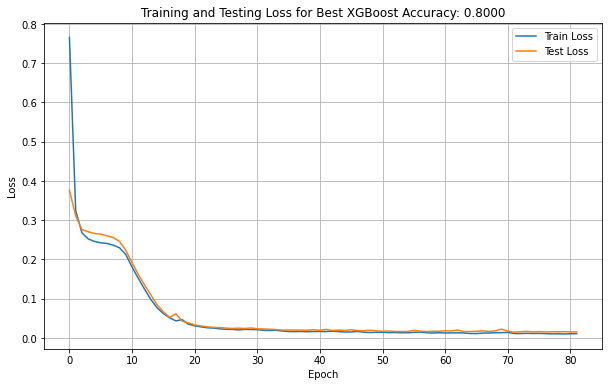

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# 读取优化结果的 CSV 文件
results_file = 'latent_optimization_results.csv'
results_df = pd.read_csv(results_file)

# 找到 SVM 准确度最高的行
best_row = results_df.loc[results_df['XGBoost Accuracy'].idxmax()]
# 打印出对应的数据
print(f'Best XGBoost Accuracy Results with LD {best_row["Latent Dimension"]}:')

# 提取训练和测试损失
train_losses = eval(best_row['Train Loss'])  # 将字符串转换为列表
test_losses = eval(best_row['Test Loss'])    # 将字符串转换为列表

# 打印最后的训练损失和测试损失
print(f"Final Train Loss: {train_losses[-1]:.6f}")  # 打印最后一个训练损失
print(f"Final Test Loss: {test_losses[-1]:.6f}")    # 打印最后一个测试损失

# 打印分类报告
print(f'\nBest XGBoost Accuracy: {best_row["XGBoost Accuracy"]:.4f}')

classification_reports = ast.literal_eval(best_row['Classification Report'])  # 将字符串转换为字典

print("\nClassification Report:")
for label, metrics in classification_reports.items():
    # 确保 'metrics' 是字典
    if isinstance(metrics, dict):  
        precision = metrics['precision']
        recall = metrics['recall']
        f1_score = metrics['f1-score']
        print(f"Label {label}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1_score:.4f}")

# 打印混淆矩阵
confusion_matrixs = ast.literal_eval(best_row['Confusion Matrix'])  # 使用 literal_eval 来解析

print("\nConfusion Matrix:")
print(f"True Negatives: {confusion_matrixs[0][0]}, False Positives: {confusion_matrixs[0][1]}")
print(f"False Negatives: {confusion_matrixs[1][0]}, True Positives: {confusion_matrixs[1][1]}")

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Testing Loss for Best XGBoost Accuracy: {best_row["XGBoost Accuracy"]:.4f}')
plt.legend()
plt.grid(True)
plt.show()